In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [19]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sys.path.append("/home/Developer/NCSN-TF2.0/")

import PIL
import utils, configs
import argparse
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from helper import plot_confusion_matrix, metrics
from ood_detection_helper import *

from datasets.dataset_loader import  *
from tqdm import tqdm
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from datetime import datetime

import matplotlib as mpl
import seaborn as sns
import plotly as py
import plotly.graph_objs as go

import umap
from sklearn.preprocessing import MinMaxScaler 

sns.set(style="darkgrid")
mpl.rcParams['figure.dpi'] = 200
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

tf.__version__

'2.2.0'

In [5]:
!du -sh ./*

2.2M	./NN_analysis.ipynb
80K	./cifar101_scores_ckpt-20.p
80K	./cifar101_scores_ckpt-9.p
35M	./cifar_dim_reduce_analysis.ipynb
17M	./cifar_vs_ood-ckpt-20_.ipynb
16M	./cifar_vs_ood-full_norm.ipynb
32M	./cifar_vs_ood.ipynb
6.9M	./cifar_vs_ood_ckpt_100_0.ipynb
35M	./cluster_analysis.ipynb
2.7M	./ood_scores.p
3.7M	./ood_scores_95_5.p
2.7M	./ood_scores_ckpt-20.p
2.7M	./ood_scores_ckpt-9.p
1.5M	./score_classifier_cifar.ipynb
2.3M	./scores_cifar_95_5.p
1.2M	./scores_ckpt-20.p
1.2M	./scores_ckpt-9.p
2.0M	./train_scores_100_0.p
2.0M	./train_scores_full_norm.p


## Train Data = L2-norm(Pixel Scores)

In [76]:
with open("train_scores_100_0.p", "rb") as f:
    train_scores = pickle.load(f)
train_scores.shape

(50000, 10)

In [77]:
with open("scores_ckpt-9.p", "rb") as f:
    score_dict = pickle.load(f)
score_dict.keys()

dict_keys(['cifar', 'celeba', 'svhn'])

In [78]:
inlier_scores = score_dict["cifar"]
outlier_scores = [score_dict["celeba"], score_dict["svhn"]]

In [79]:
with open("ood_scores_ckpt-9.p", "rb") as f:
    ood_dict = pickle.load(f)
outlier_scores.extend([x for x in ood_dict.values()])

In [80]:
ood_names = list(score_dict.keys())[1:] + list(ood_dict.keys())
ood_names, len(outlier_scores)

(['celeba',
  'svhn',
  'LSUN',
  'LSUN_resize',
  'Imagenet',
  'Imagenet_resize',
  'iSUN',
  'gaussian',
  'uniform'],
 9)

In [81]:
LABELS = np.array(["Train", "CIFAR", "CelebA", "SVHN", 'LSUN','LSUN_resize',
                   'Imagenet','Imagenet_resize','iSUN',"Gaussian", "Uniform"])
COLORS = sns.color_palette("bright")

In [83]:
X_train = train_scores.copy()
X_test = inlier_scores.copy()

## KD Tree

In [84]:
from sklearn.neighbors import NearestNeighbors
N_NEIGHBOURS = 5

In [85]:
%%time
nbrs = NearestNeighbors(n_neighbors=N_NEIGHBOURS, algorithm='kd_tree').fit(X_train)

train_distances, indices = nbrs.kneighbors(X_train)

ood_dists = {}
test_distances, _ = nbrs.kneighbors(X_test)

for name, ood in zip(ood_names, outlier_scores):
    dists, _ = nbrs.kneighbors(ood)
    ood_dists[name] = dists 

CPU times: user 24.8 s, sys: 76.2 ms, total: 24.9 s
Wall time: 24.9 s


CIFAR vs k=2
----------------
ROC-AUC: 99.5002
PR-AUC (In/Out): 85.0767 / 99.9897
FPR (95% TPR): 2.41%
Detection Error: 3.27%
CIFAR vs k=3
----------------
ROC-AUC: 99.4304
PR-AUC (In/Out): 83.6488 / 99.9880
FPR (95% TPR): 2.72%
Detection Error: 3.44%
CIFAR vs k=4
----------------
ROC-AUC: 99.4248
PR-AUC (In/Out): 82.7403 / 99.9878
FPR (95% TPR): 2.77%
Detection Error: 3.34%
CIFAR vs k=5
----------------
ROC-AUC: 99.3893
PR-AUC (In/Out): 82.0869 / 99.9868
FPR (95% TPR): 2.75%
Detection Error: 3.58%


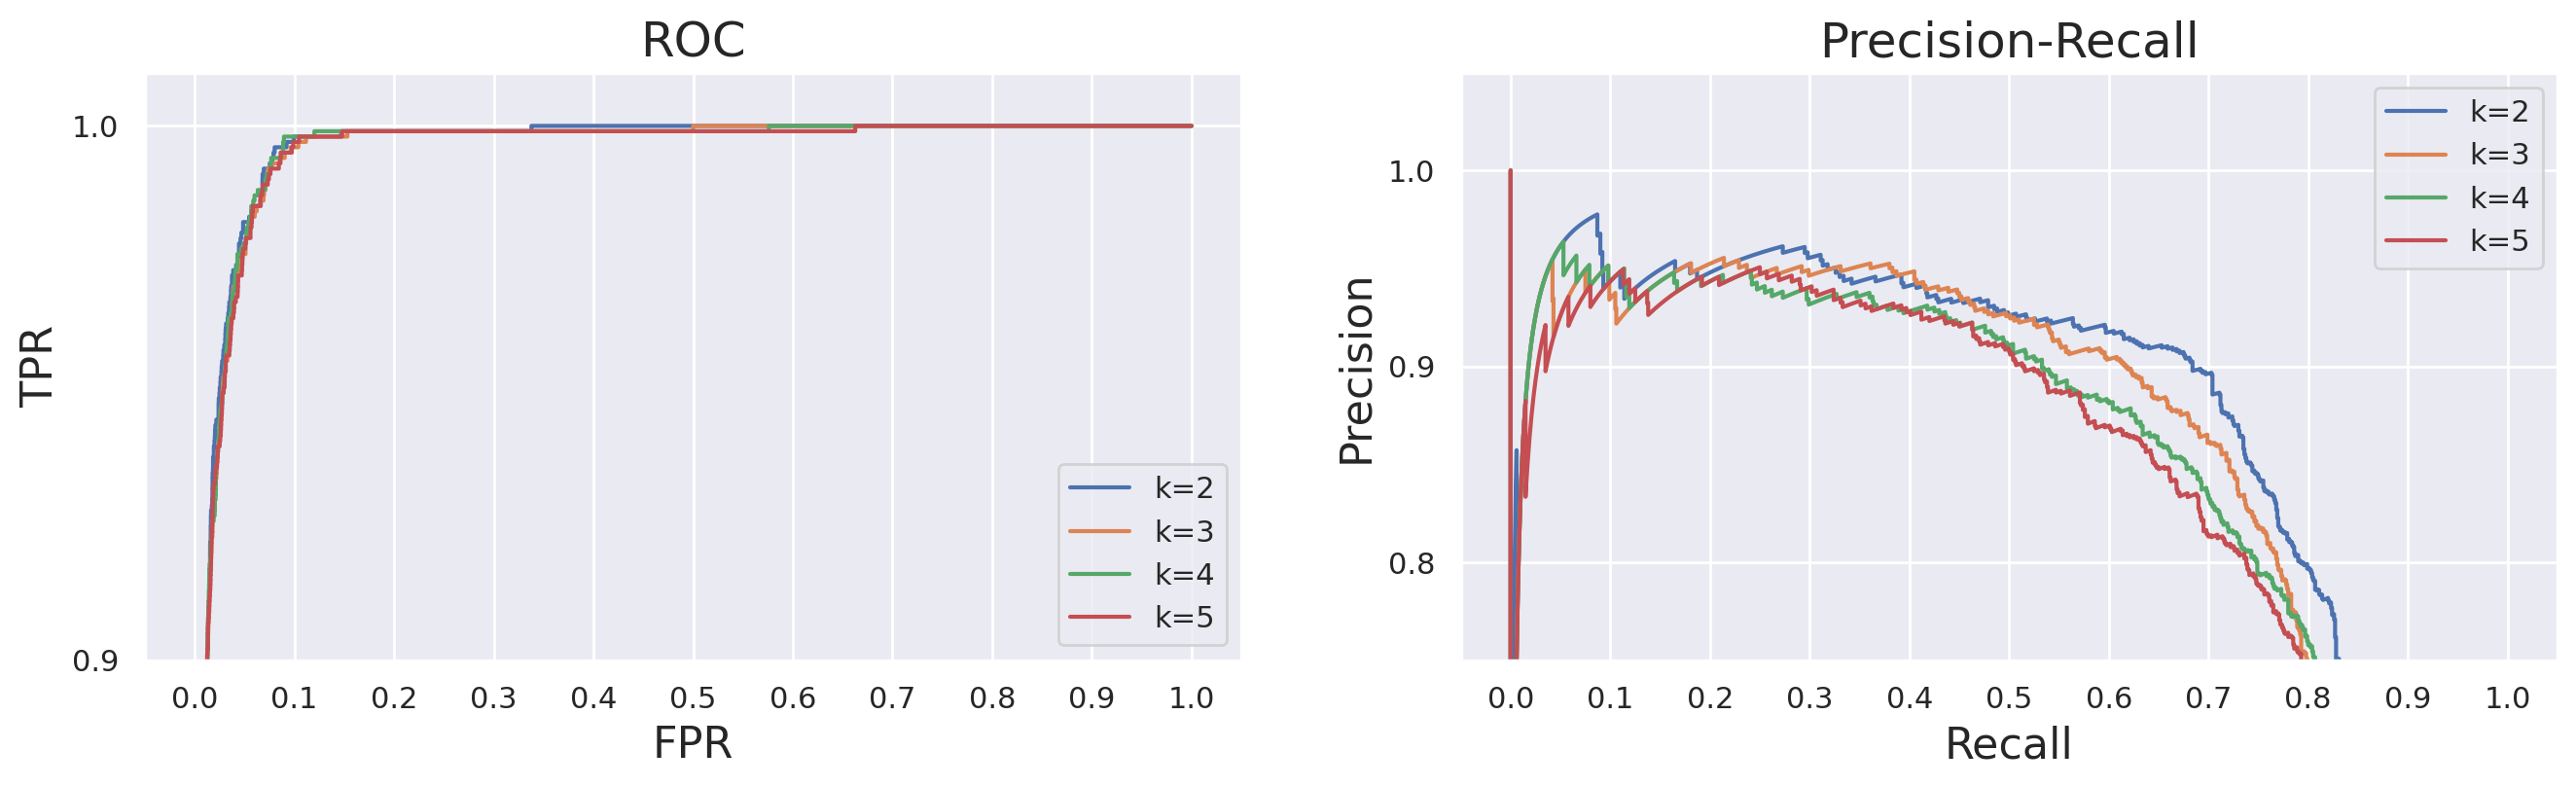

In [86]:
fig, axs = plt.subplots(1,2, figsize=(16,4))
ticks = np.arange(0.0, 1.1, step=0.1)

for k in range(1,N_NEIGHBOURS, 1):
    inlier_score = train_distances[:,k]
    outlier_score = ood_dists["svhn"][:1000, k]
#     outlier_score = test_distances[:,k]
    
    ood_metrics(inlier_score,outlier_score, names=("CIFAR", "k={}".format(k+1)), plot=False, verbose=True)
    
    
    y_true = np.concatenate((np.zeros(len(inlier_score)),
                                 np.ones(len(outlier_score))))
    y_scores = np.concatenate((inlier_score, outlier_score))
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, drop_intermediate=True)
    prec_in, rec_in, _ = precision_recall_curve(y_true, y_scores)
    _label = "k={:d}".format(k+1)
    
    axs[0].plot(fpr, tpr, label=_label)
    axs[1].plot(rec_in, prec_in, label=_label)
    
    
    
axs[0].set(
    xlabel="FPR", ylabel="TPR", title="ROC", ylim=(0.9, 1.01),
    xticks=ticks, yticks=ticks
)
axs[0].legend()

axs[1].set(
        xlabel="Recall", ylabel="Precision", title="Precision-Recall", ylim=(0.75, 1.05),
        xticks=ticks, yticks=ticks
)
axs[1].legend()
# fig.suptitle("{} vs {}".format(*names), fontsize=20)
plt.show()
plt.close()

In [87]:
for name, dists in ood_dists.items():
    ood_metrics(test_distances[:,-1], dists[:,-1], names=("CIFAR", name), plot=False, verbose=True)
    print()

CIFAR vs celeba
----------------
ROC-AUC: 62.6872
PR-AUC (In/Out): 56.9791 / 66.5376
FPR (95% TPR): 78.55%
Detection Error: 39.27%

CIFAR vs svhn
----------------
ROC-AUC: 99.1484
PR-AUC (In/Out): 99.0696 / 99.2088
FPR (95% TPR): 4.11%
Detection Error: 4.48%

CIFAR vs LSUN
----------------
ROC-AUC: 99.9465
PR-AUC (In/Out): 99.9427 / 99.9510
FPR (95% TPR): 0.23%
Detection Error: 0.86%

CIFAR vs LSUN_resize
----------------
ROC-AUC: 99.8585
PR-AUC (In/Out): 99.8384 / 99.8742
FPR (95% TPR): 0.57%
Detection Error: 1.45%

CIFAR vs Imagenet
----------------
ROC-AUC: 99.8647
PR-AUC (In/Out): 99.8433 / 99.8814
FPR (95% TPR): 0.51%
Detection Error: 1.40%

CIFAR vs Imagenet_resize
----------------
ROC-AUC: 99.9339
PR-AUC (In/Out): 99.9264 / 99.9408
FPR (95% TPR): 0.25%
Detection Error: 0.99%

CIFAR vs iSUN
----------------
ROC-AUC: 99.8926
PR-AUC (In/Out): 99.8624 / 99.9144
FPR (95% TPR): 0.39%
Detection Error: 1.25%

CIFAR vs gaussian
----------------
ROC-AUC: 100.0000
PR-AUC (In/Out): 100.0000

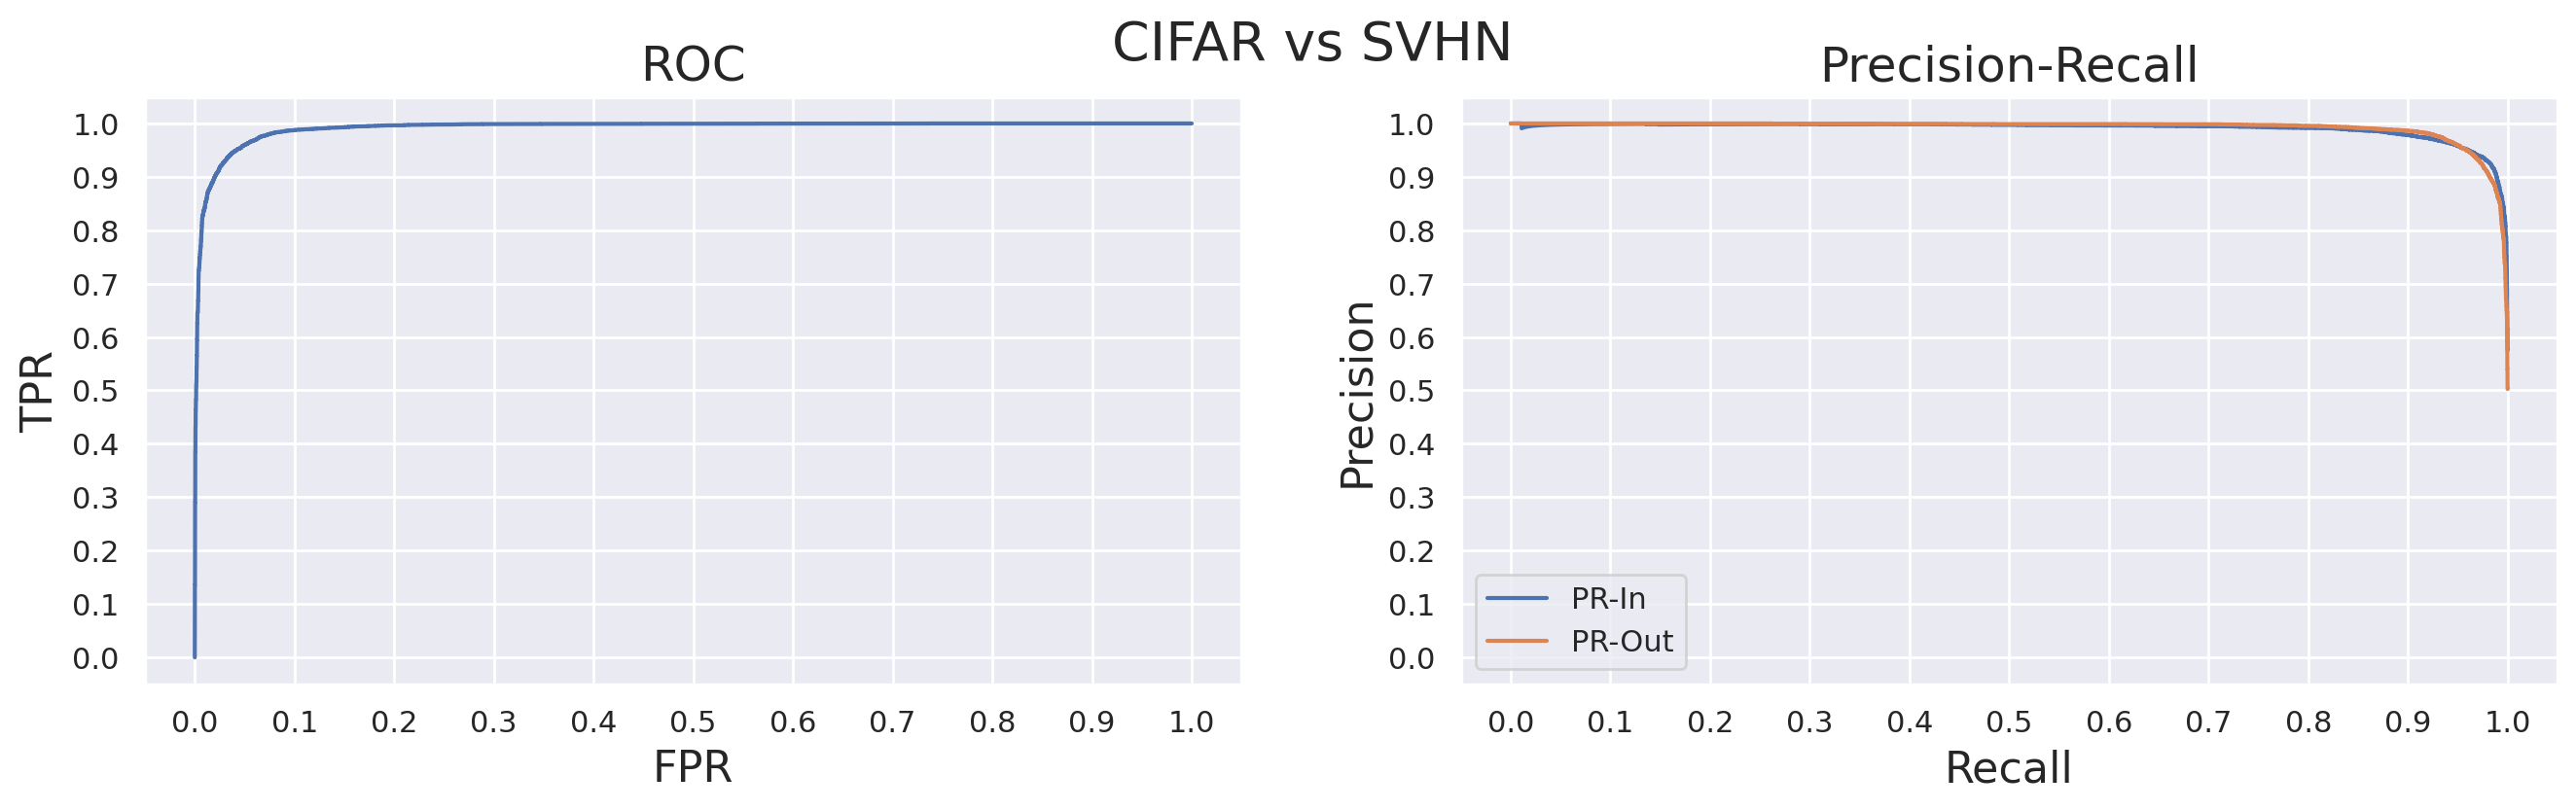

CIFAR vs SVHN
----------------
ROC-AUC: 99.1484
PR-AUC (In/Out): 99.0696 / 99.2088
FPR (95% TPR): 4.11%
Detection Error: 4.48%


{'roc_auc': 0.9914839700000001,
 'fpr_tpr95': 0.0411,
 'fpr_tpr80': 0.0069,
 'pr_auc_in': 0.9906961651441349,
 'pr_auc_out': 0.9920880827440841,
 'ap': 0.9906971353462364,
 'de': 0.044800000000000006}

In [90]:
ood_metrics(test_distances[:,-1], ood_dists["svhn"][:,-1], names=("CIFAR", "SVHN"), plot=True, verbose=True)

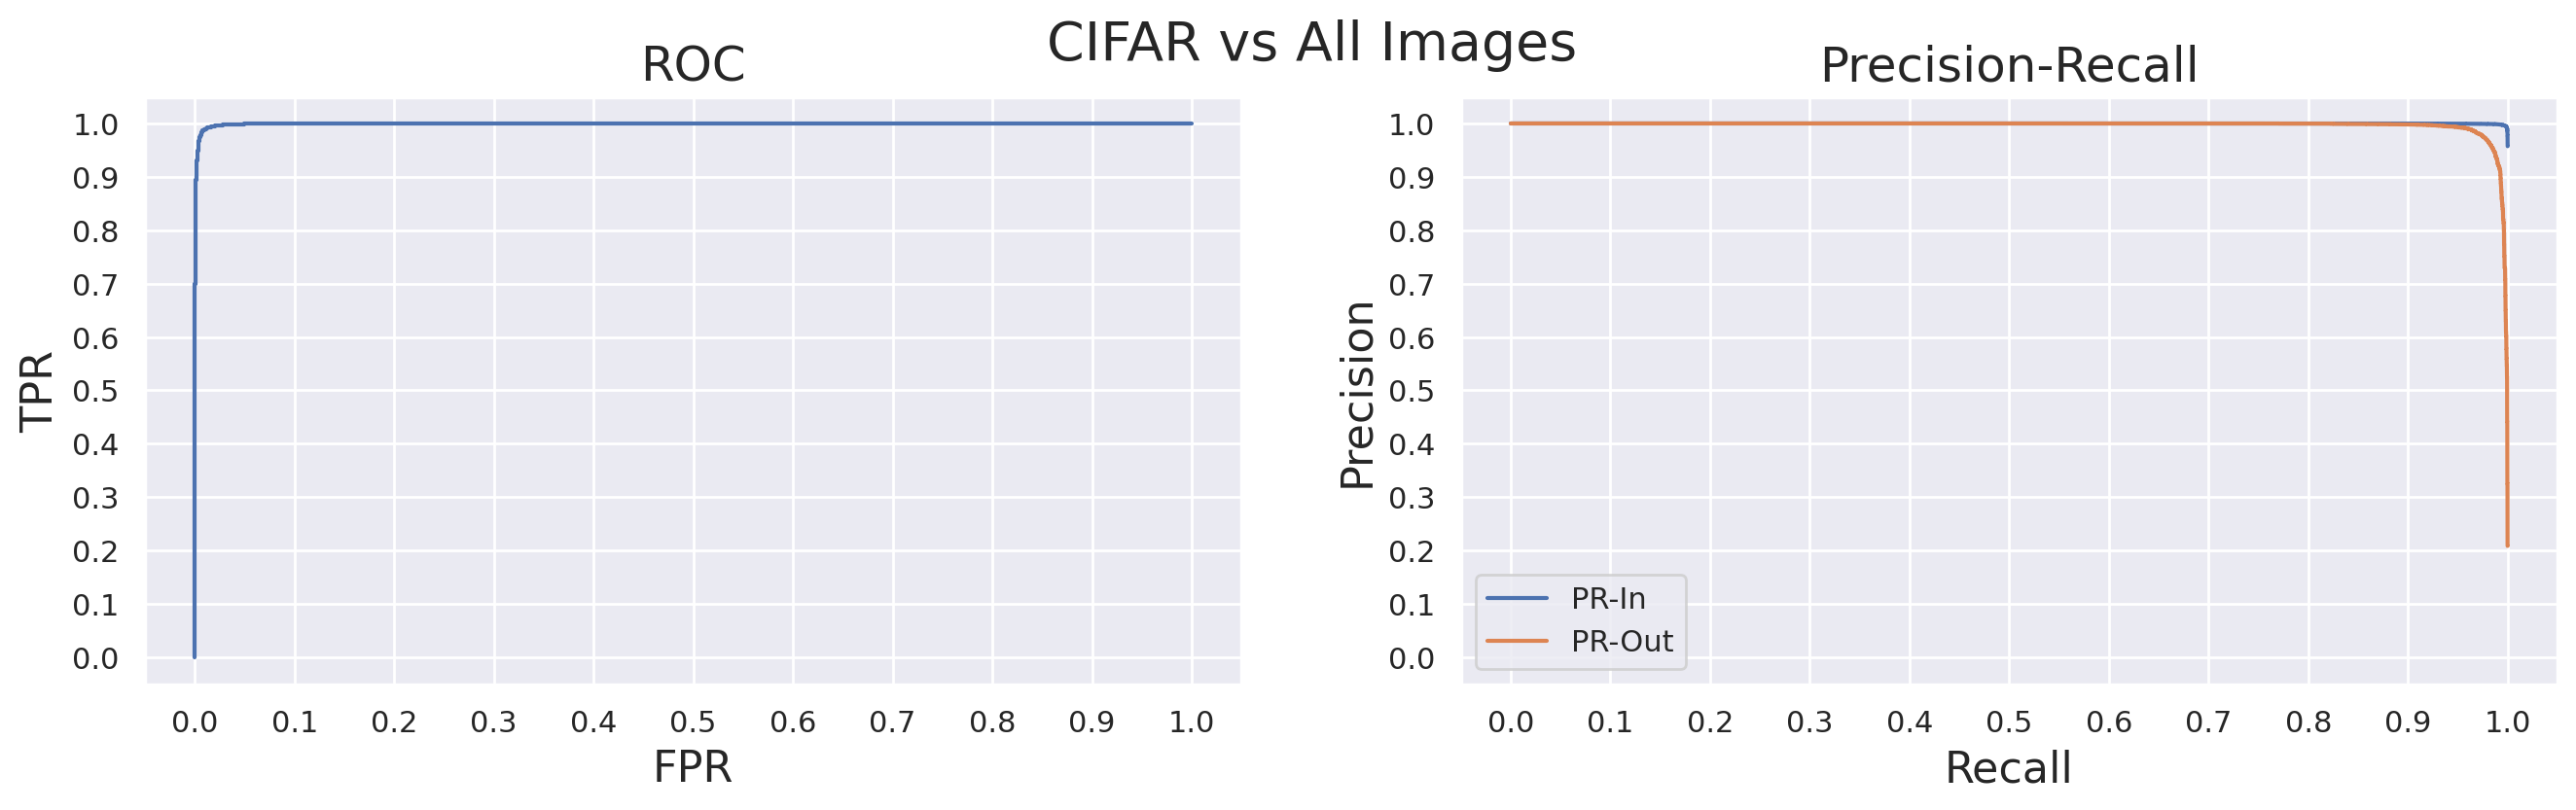

CIFAR vs All Images
----------------
ROC-AUC: 99.9286
PR-AUC (In/Out): 99.9889 / 99.6562
FPR (95% TPR): 0.31%
Detection Error: 1.04%


{'roc_auc': 0.9992858237214364,
 'fpr_tpr95': 0.0031,
 'fpr_tpr80': 0.0003,
 'pr_auc_in': 0.9998887452340941,
 'pr_auc_out': 0.9965619369044345,
 'ap': 0.9998887461200967,
 'de': 0.010443271672107374}

In [88]:
#Skipping SVHN, CelebA
include = ood_names[2:]
combined_distances = np.concatenate([ood_dists[name] for name in include]) 
ood_metrics(test_distances[:,-1], combined_distances[:,-1], names=(LABELS[1], "All Images"),plot=True, verbose=True)

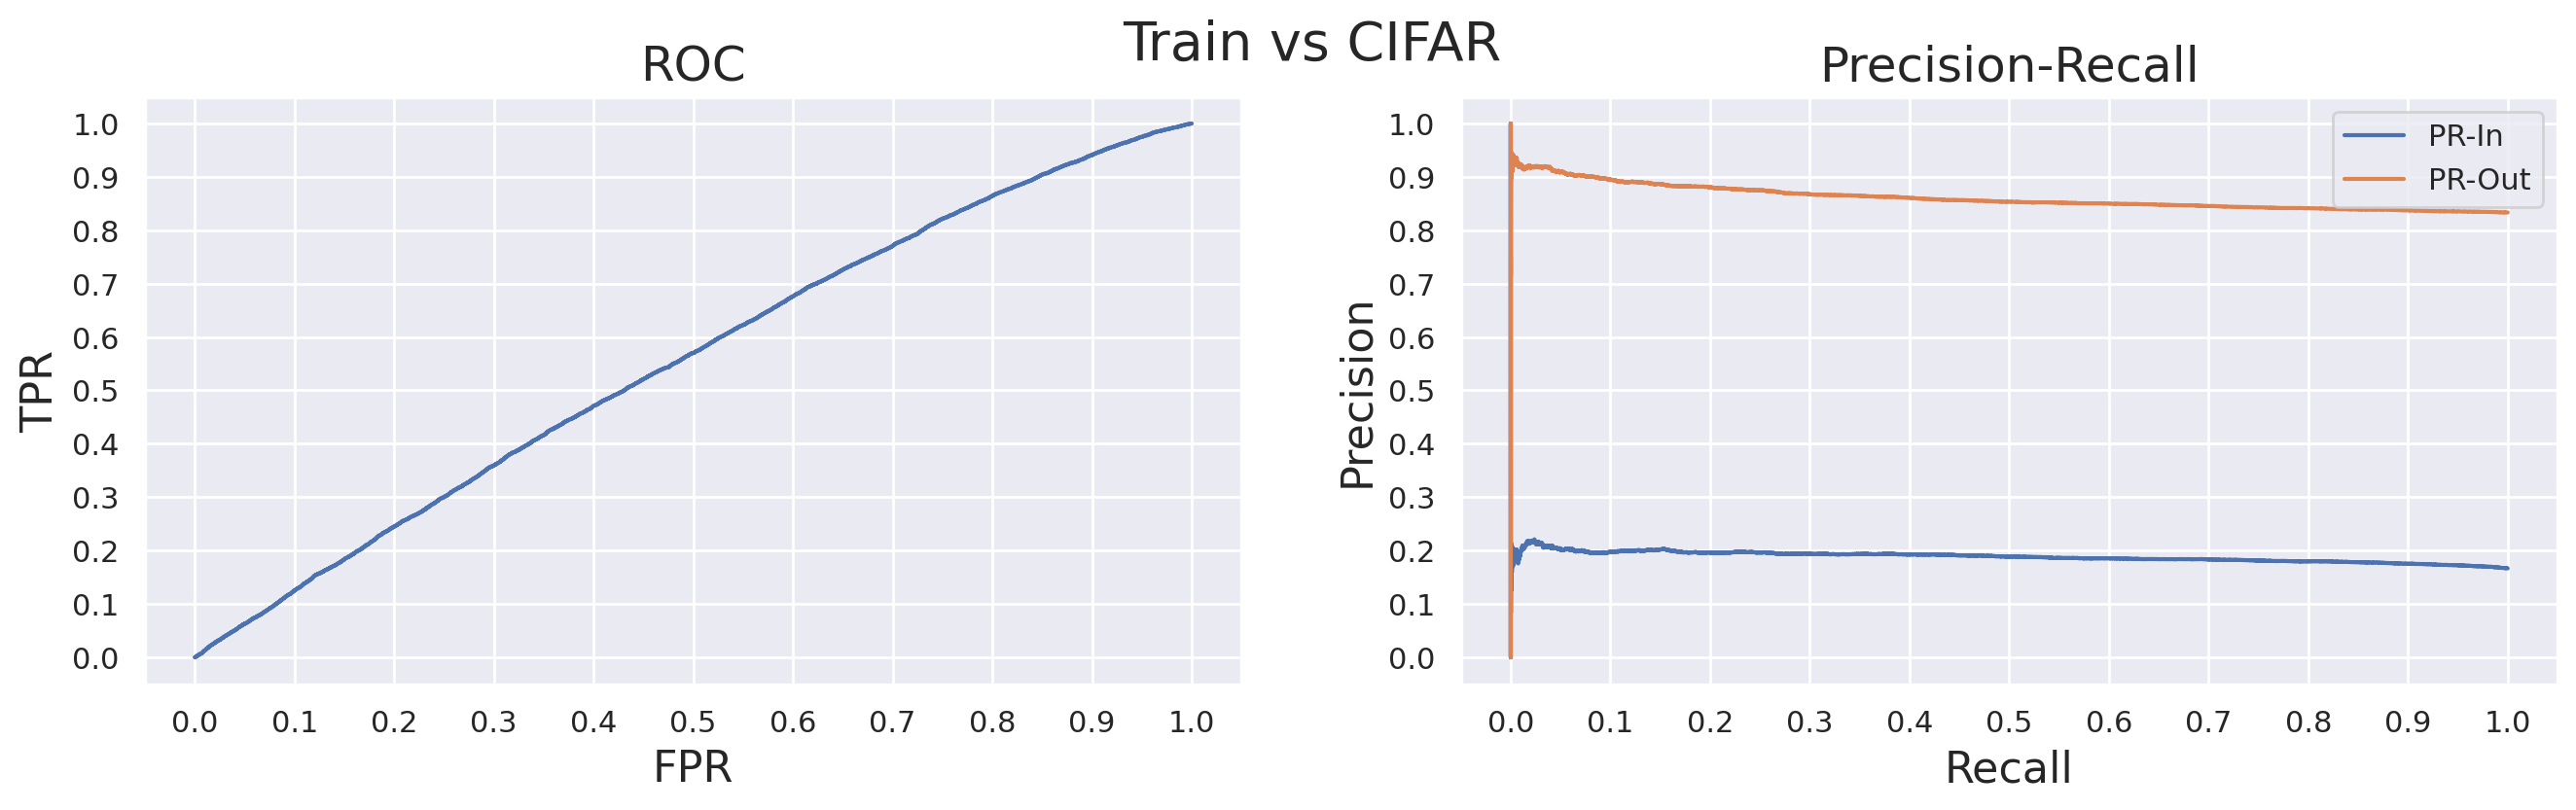

Train vs CIFAR
----------------
ROC-AUC: 55.2840
PR-AUC (In/Out): 18.8324 / 86.0710
FPR (95% TPR): 91.09%
Detection Error: 46.07%


{'roc_auc': 0.552839922,
 'fpr_tpr95': 0.91088,
 'fpr_tpr80': 0.72884,
 'pr_auc_in': 0.18832372951924875,
 'pr_auc_out': 0.8607102295805986,
 'ap': 0.18840465215808516,
 'de': 0.46065999999999996}

In [69]:
ood_metrics(train_distances[:,-1], test_distances[:,-1], names=(LABELS[0], LABELS[1]),plot=True, verbose=True)

## KDE

In [40]:
from sklearn.neighbors import KernelDensity as KDE

In [69]:
%%time
kde = KDE(kernel="gaussian", bandwidth=0.5).fit(X_train)

CPU times: user 104 ms, sys: 1.92 ms, total: 106 ms
Wall time: 103 ms


In [70]:
%%time
train_score = kde.score_samples(X_train)
test_score = kde.score_samples(X_test)
ood_scores = [kde.score_samples(ood) for ood in outlier_scores]

CPU times: user 7min 19s, sys: 1.92 s, total: 7min 21s
Wall time: 7min 19s


2
3
4
5
6
7
8
9
10


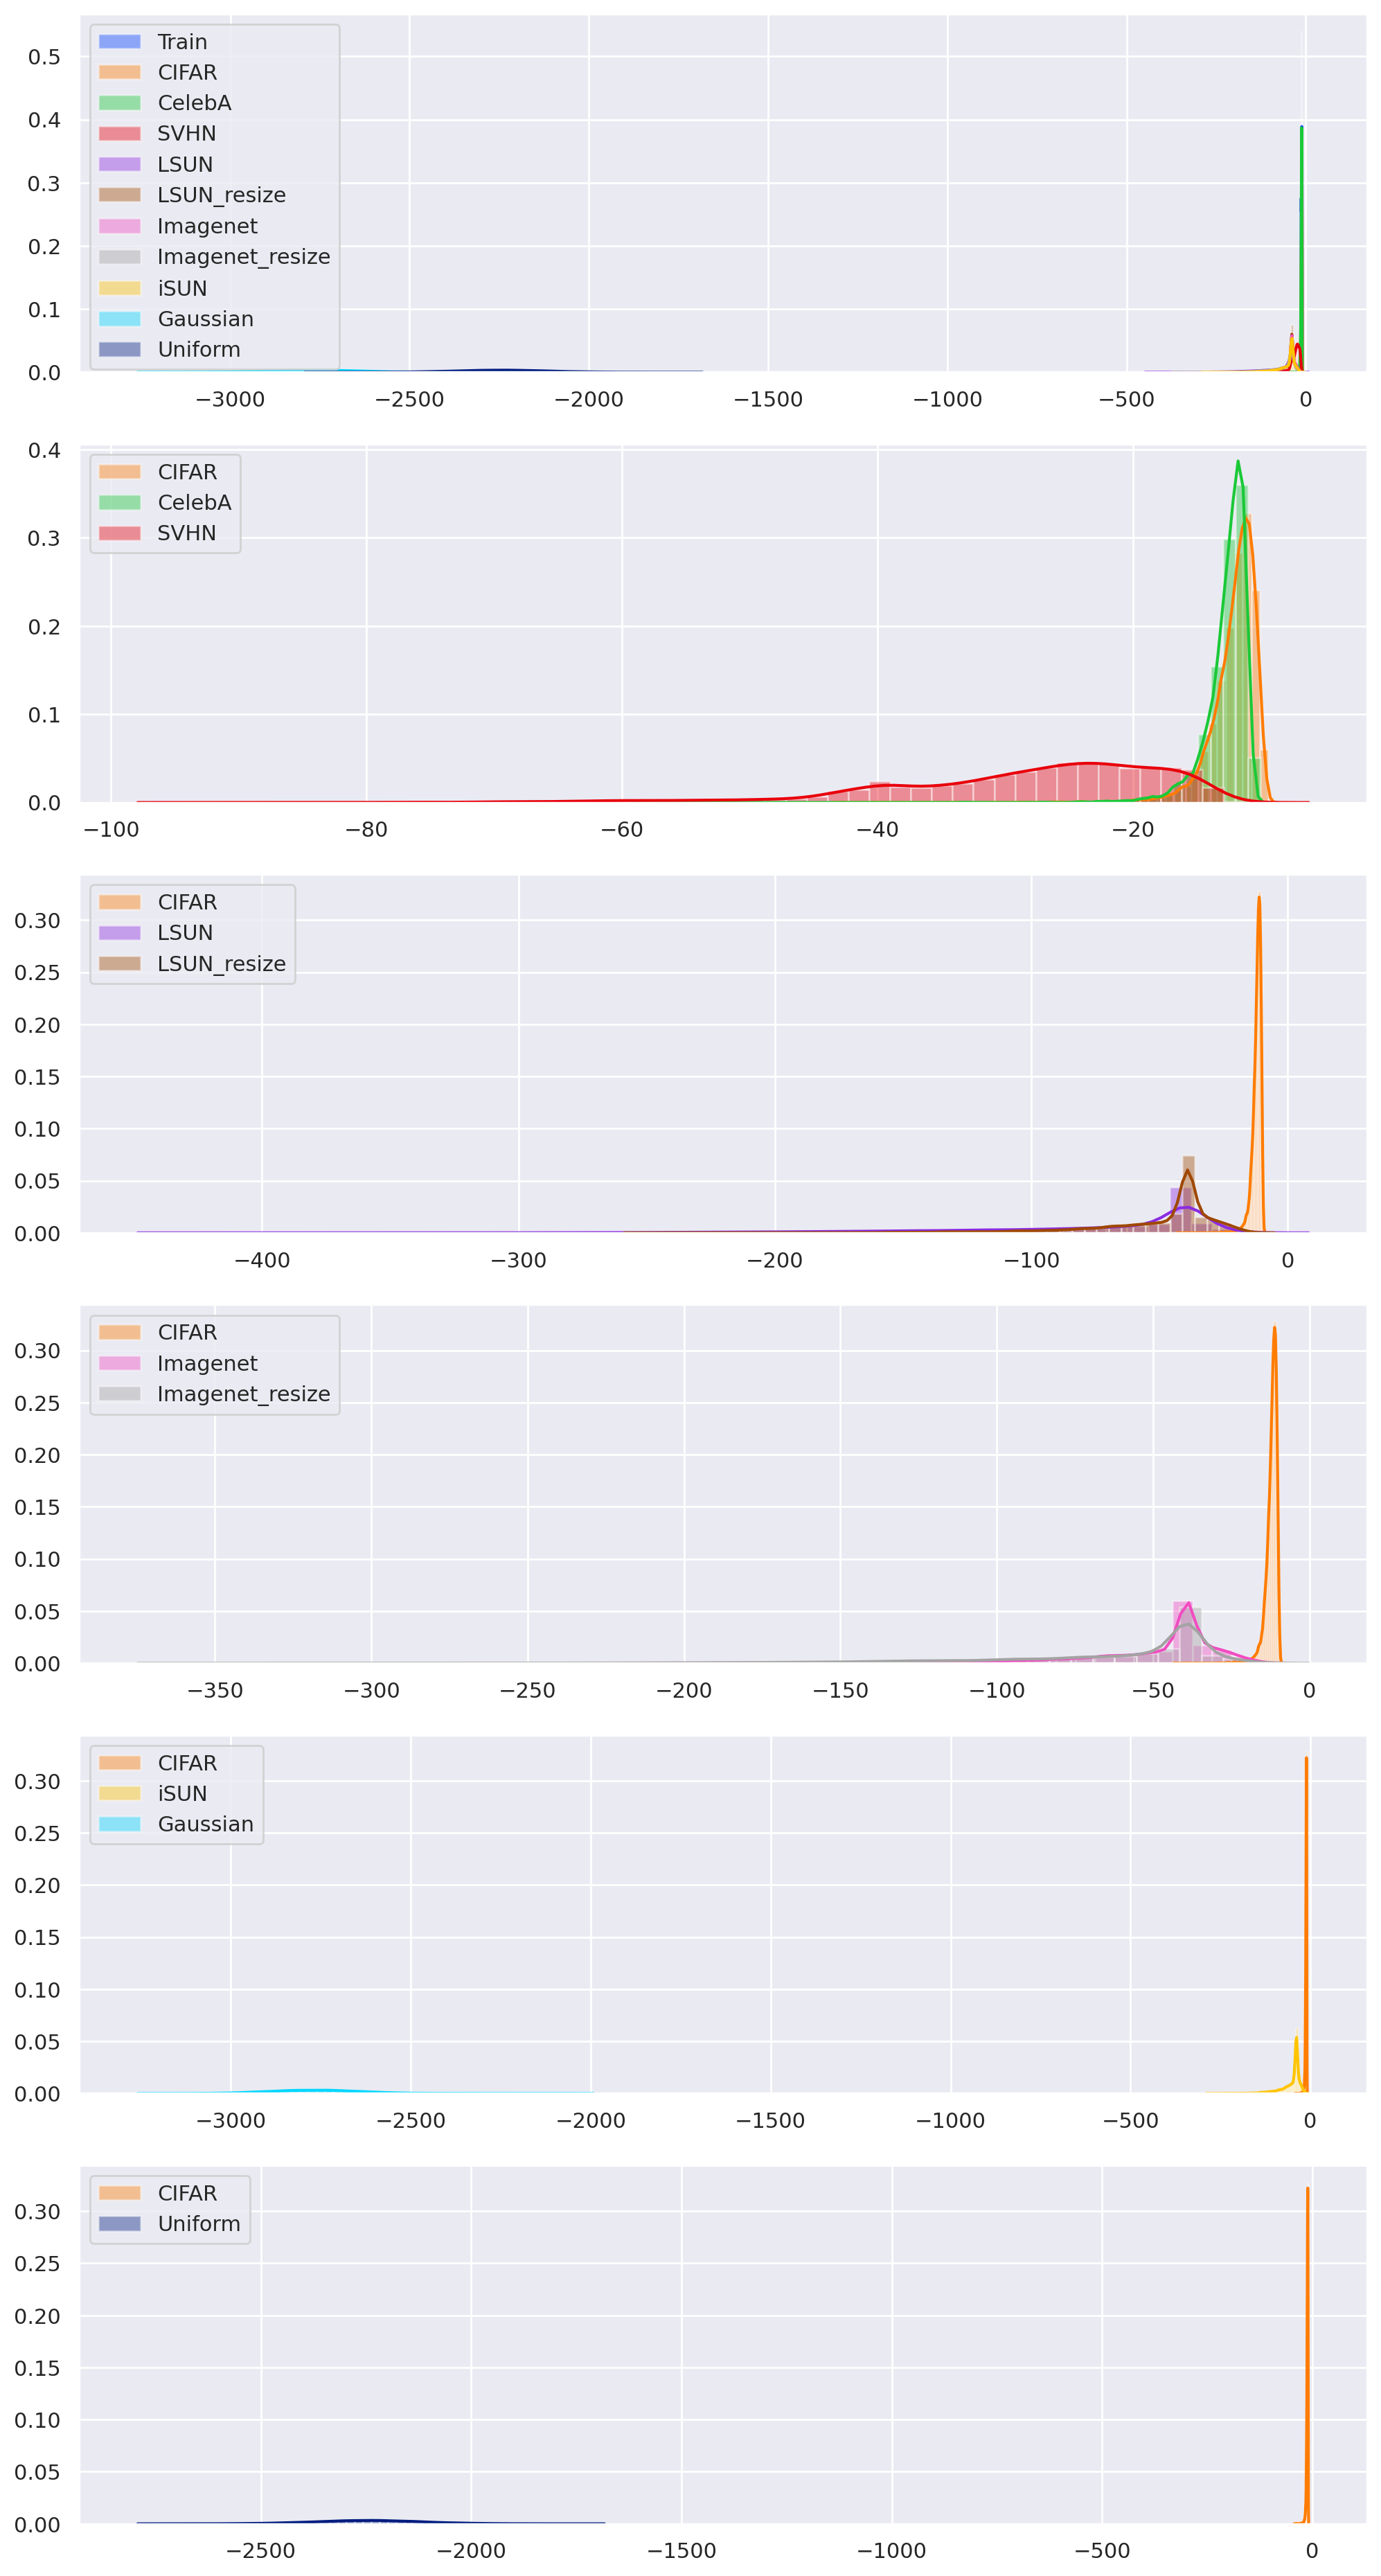

In [75]:
evaluate_model(train_score, test_score, ood_scores, labels=LABELS)

In [76]:
for idx, _score in enumerate(ood_scores):
    ood_metrics(-test_score, -_score, names=(LABELS[1], LABELS[idx+2]),
                    plot=False, verbose=True)
    print()

CIFAR vs CelebA
----------------
ROC-AUC: 0.6389
PR-AUC (In/Out): 0.5782 / 0.7024
FPR (95% TPR) Prec: 0.7137

CIFAR vs SVHN
----------------
ROC-AUC: 0.9896
PR-AUC (In/Out): 0.9887 / 0.9906
FPR (95% TPR) Prec: 0.0535

CIFAR vs LSUN
----------------
ROC-AUC: 0.9997
PR-AUC (In/Out): 0.9997 / 0.9997
FPR (95% TPR) Prec: 0.0006

CIFAR vs LSUN_resize
----------------
ROC-AUC: 0.9992
PR-AUC (In/Out): 0.9992 / 0.9993
FPR (95% TPR) Prec: 0.0021

CIFAR vs Imagenet
----------------
ROC-AUC: 0.9993
PR-AUC (In/Out): 0.9992 / 0.9994
FPR (95% TPR) Prec: 0.0020

CIFAR vs Imagenet_resize
----------------
ROC-AUC: 0.9996
PR-AUC (In/Out): 0.9996 / 0.9997
FPR (95% TPR) Prec: 0.0007

CIFAR vs iSUN
----------------
ROC-AUC: 0.9994
PR-AUC (In/Out): 0.9993 / 0.9996
FPR (95% TPR) Prec: 0.0013

CIFAR vs Gaussian
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.0000

CIFAR vs Uniform
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.000

In [ ]:
# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.logspace(-1, 1, 10),
          "kernel": ["gaussian","tophat","epanechnikov","exponential","linear","cosine"],
          "algorithm": ["kd_tree", "ball_tree"]
         }
grid = GridSearchCV(KDE(), params, cv=10, n_jobs=12,
                        verbose=1)
grid_result = grid.fit(X_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   21.5s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.4min
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:  8.2min
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed: 18.0min


In [111]:
plt.figure(figsize=(10,6))
plt.bar([p["kernel"] for p in params], means)

TypeError: string indices must be integers

<Figure size 2000x1200 with 0 Axes>

In [ ]:
# use the best estimator to compute the kernel density estimate
kde = grid.best_estimator_

In [ ]:
%%time
train_score = kde.score_samples(X_train)
test_score = kde.score_samples(X_test)
ood_scores = [kde.score_samples(ood) for ood in outlier_scores]

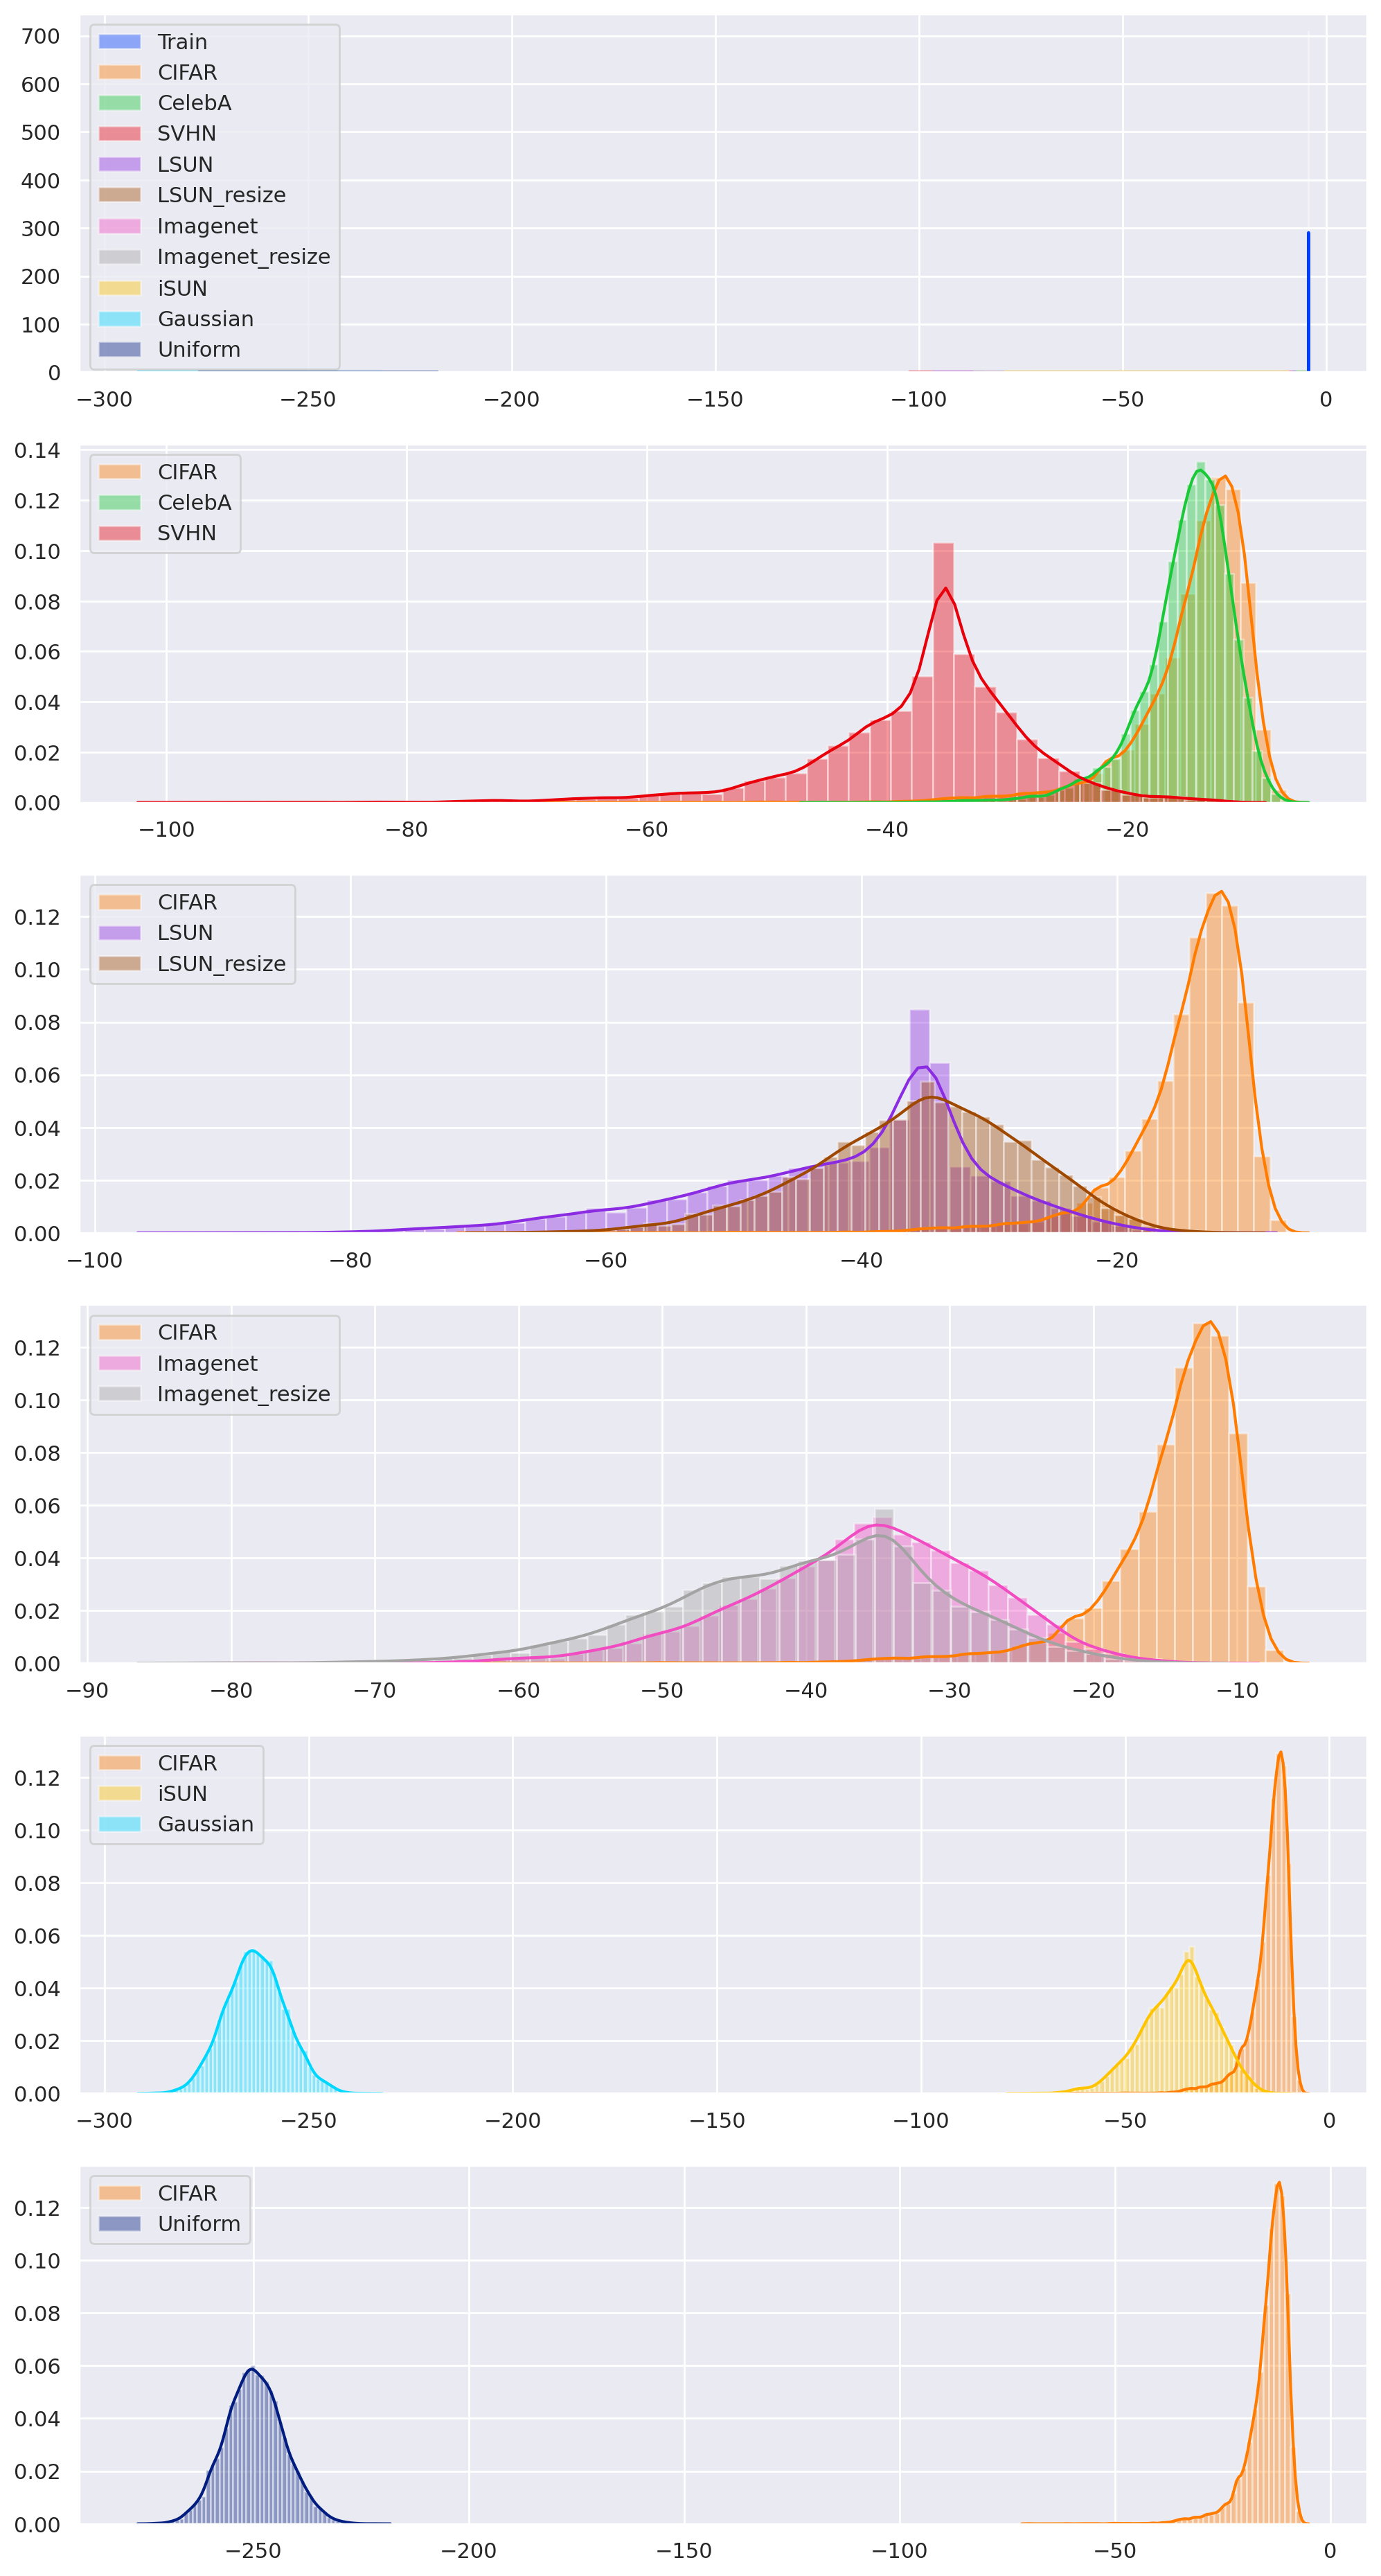

In [114]:
evaluate_model(train_score, test_score, ood_scores, labels=LABELS)

In [116]:
for idx, _score in enumerate(ood_scores):
    ood_metrics(-test_score, -_score, names=(LABELS[1], LABELS[idx+2]),
                    plot=False, verbose=True)
    print()

CIFAR vs CelebA
----------------
ROC-AUC: 0.5840
PR-AUC (In/Out): 0.5326 / 0.5919
FPR (95% TPR) Prec: 89.01%

CIFAR vs SVHN
----------------
ROC-AUC: 0.9871
PR-AUC (In/Out): 0.9831 / 0.9886
FPR (95% TPR) Prec: 3.66%

CIFAR vs LSUN
----------------
ROC-AUC: 0.9922
PR-AUC (In/Out): 0.9899 / 0.9936
FPR (95% TPR) Prec: 3.00%

CIFAR vs LSUN_resize
----------------
ROC-AUC: 0.9847
PR-AUC (In/Out): 0.9784 / 0.9877
FPR (95% TPR) Prec: 5.36%

CIFAR vs Imagenet
----------------
ROC-AUC: 0.9863
PR-AUC (In/Out): 0.9806 / 0.9890
FPR (95% TPR) Prec: 4.86%

CIFAR vs Imagenet_resize
----------------
ROC-AUC: 0.9914
PR-AUC (In/Out): 0.9884 / 0.9930
FPR (95% TPR) Prec: 3.27%

CIFAR vs iSUN
----------------
ROC-AUC: 0.9875
PR-AUC (In/Out): 0.9806 / 0.9908
FPR (95% TPR) Prec: 4.65%

CIFAR vs Gaussian
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.00%

CIFAR vs Uniform
----------------
ROC-AUC: 1.0000
PR-AUC (In/Out): 1.0000 / 1.0000
FPR (95% TPR) Prec: 0.00%



In [113]:
kde.get_params()

{'algorithm': 'ball_tree',
 'atol': 0,
 'bandwidth': 0.16681005372000587,
 'breadth_first': True,
 'kernel': 'exponential',
 'leaf_size': 40,
 'metric': 'euclidean',
 'metric_params': None,
 'rtol': 0}